In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/crashes/DTP_DATA_2025_PROCESSED.csv
/kaggle/input/fonts/HSESans-Regular.otf


In [2]:
import seaborn as sns
from catboost import Pool, CatBoostClassifier

In [3]:
data = pd.read_csv("/kaggle/input/crashes/DTP_DATA_2025_PROCESSED.csv")

In [4]:
data.sample(5)

,Unnamed: 0,REGION,DATE,COORD_L,COORD_W,road_name,road_category,n_VEHICLES,n_PARTICIPANTS,ID,...,site_objects_cat,severity,YEAR,MONTH,WEEKDAY,SEASON,is_WEEKEND,HOUR,is_NIGHT,is_PEAK_HOUR
459779,1435358,97,12.06.2016,47.094700,55.283300,КАЛИНИНО-БАТЫРЕВО-ЯЛЬЧИКИ,6.0,1,1,194025982,...,12,3,2016,6,6,3,1,16,0,1
228304,704756,45,16.07.2015,37.658900,55.788900,Внутренняя сторона,1.0,2,2,174225494,...,3,2,2015,7,3,3,0,3,1,0
131553,390455,24,29.01.2015,42.178900,56.486930,Ростов-Иваново-Нижний Новгород,5.0,1,2,161013709,...,12,1,2015,1,3,1,0,13,0,0
358625,1142022,71,30.10.2020,68.484564,56.339284,Голышманово - Бердюжье,6.0,1,2,221027287,...,12,2,2020,10,4,4,0,20,0,0
242475,791586,46,20.10.2015,38.926389,55.602778,А-108 Московское большое кольцо Дмитров - Серг...,3.0,2,3,181252737,...,12,1,2015,10,1,4,0,19,0,0


In [5]:
cat_features = [
    # "road_category",
    "vehicle_failure",
    "non_private_vehicle",
    "russian_vehicle",
    "white_vehicle",
    "black_vehicle",
    "colored_vehicle",
    "drunk_driver",
    "female_driver",
    "escaped",
    "no_seatbelt_injury",
    "is_WEEKEND",
    "is_NIGHT",
    "is_PEAK_HOUR",
    "road_rank_cat",
    "road_defects_cat",
    "traffic_changes_cat",
    "road_surface_cat",
    "TYPE_cat",
    "out_of_town",
    "street_rank_cat",
    "weather_cat",
    "adj_objects_cat",
    "cause_factors_cat",
    "crossing_violation",
    "impaired_driving",
    "interference_violation",
    "license_violation",
    "maneuver_violation",
    "other_violation",
    "pedestrian_violation",
    "sudden_appearance_violation",
    "traffic_control_violation",
    "transport_violation",
    "vehicle_tech_violation",
    "wrong_way",
    "lighting_cat",
    "site_objects_cat",
    "weather_interpretable",
    "adj_objects_interpretable",
]


In [6]:
cols2drop = ['severity', 'Unnamed: 0', 'REGION', 'DATE', 'COORD_L', 'COORD_W', 'road_category', 'ID', 'YEAR', 'defects', 'TYPE', 'NP', 'road_name', 'n_DEATHS', 'n_INJURED', 'n_PARTICIPANTS', 'n_VEHICLES', 'guilty_share']
target = ['severity']

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score

In [8]:
data.shape[0]

473188

In [9]:
X = data.drop(columns=cols2drop, errors='ignore')
y = data[target]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2,random_state=101)
clf = CatBoostClassifier(cat_features=cat_features, task_type='GPU', random_state=101)
train = Pool(data=X_train, label=y_train, cat_features=cat_features)
clf.fit(train, verbose=100)
preds = clf.predict(X_val)

clf.save_model('cat_model.cbm')
print(f"Macro-F1 модели на валидационном сете: {f1_score(y_val, preds, average='macro')}")
print(f"Accuracy модели на валидационном сете: {accuracy_score(y_val, preds)}")

Learning rate set to 0.217882
0:	learn: 1.0600518	total: 7.24s	remaining: 2h 27s
100:	learn: 0.9325183	total: 8.41s	remaining: 1m 14s
200:	learn: 0.9249721	total: 9.53s	remaining: 37.9s
300:	learn: 0.9198607	total: 10.6s	remaining: 24.7s
400:	learn: 0.9151739	total: 11.8s	remaining: 17.6s
500:	learn: 0.9106981	total: 12.9s	remaining: 12.8s
600:	learn: 0.9067633	total: 14.1s	remaining: 9.35s
700:	learn: 0.9030969	total: 15.3s	remaining: 6.52s
800:	learn: 0.8994585	total: 16.5s	remaining: 4.09s
900:	learn: 0.8958697	total: 17.6s	remaining: 1.94s
999:	learn: 0.8921592	total: 18.8s	remaining: 0us
Macro-F1 модели на валидационном сете: 0.4664349617663152
Accuracy модели на валидационном сете: 0.5178046873348972


In [22]:
data.shape[0]

473188

In [10]:
imp = clf.get_feature_importance(prettified=True)[:8]

In [11]:
imp

,Feature Id,Importances
0,TYPE_cat,6.036792
1,wrong_way,5.809080
2,exp_avg,4.553868
3,traffic_changes_bin,3.866508
4,maneuver_violation,3.635236
5,impaired_driving,3.587720
6,transport_violation,3.098867
7,site_objects_cat,3.051509


In [18]:
import matplotlib.pyplot as plt
import matplotlib

In [13]:
font_path = "/kaggle/input/fonts/HSESans-Regular.otf"

In [19]:
if os.path.exists(font_path):
    # Добавляем шрифт в matplotlib
    matplotlib.font_manager.fontManager.addfont(font_path)
    font_name = matplotlib.font_manager.FontProperties(fname=font_path).get_name()
    plt.rcParams['font.family'] = font_name
    print(f"✅ Шрифт '{font_name}' успешно загружен")
else:
    print("⚠️  Шрифт не найден по указанному пути. Используется стандартный шрифт.")
    print(f"Путь: {font_path}")

✅ Шрифт 'HSE Sans' успешно загружен


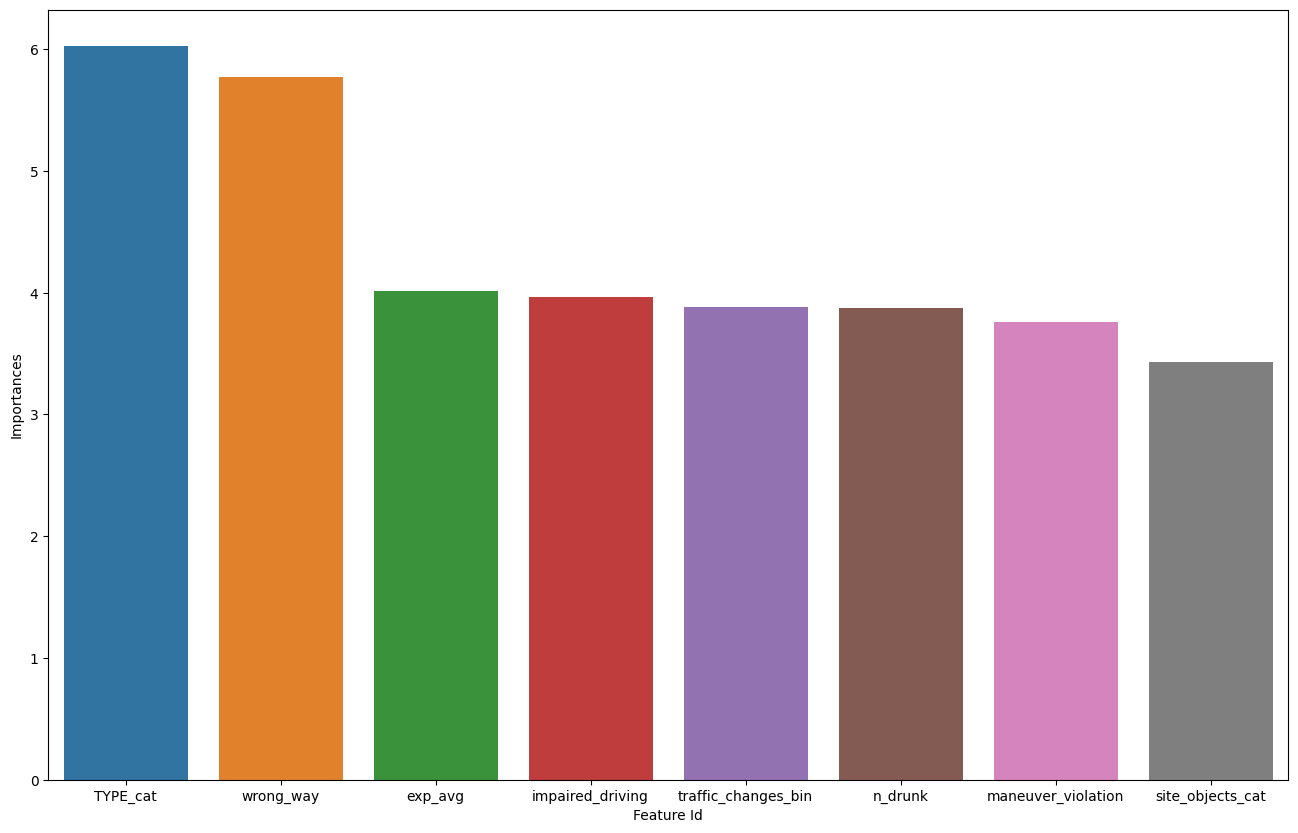

In [12]:
plt.figure(figsize=(16, 10))
sns.barplot(x=imp['Feature Id'], y=imp['Importances'])
plt.savefig("features.png")

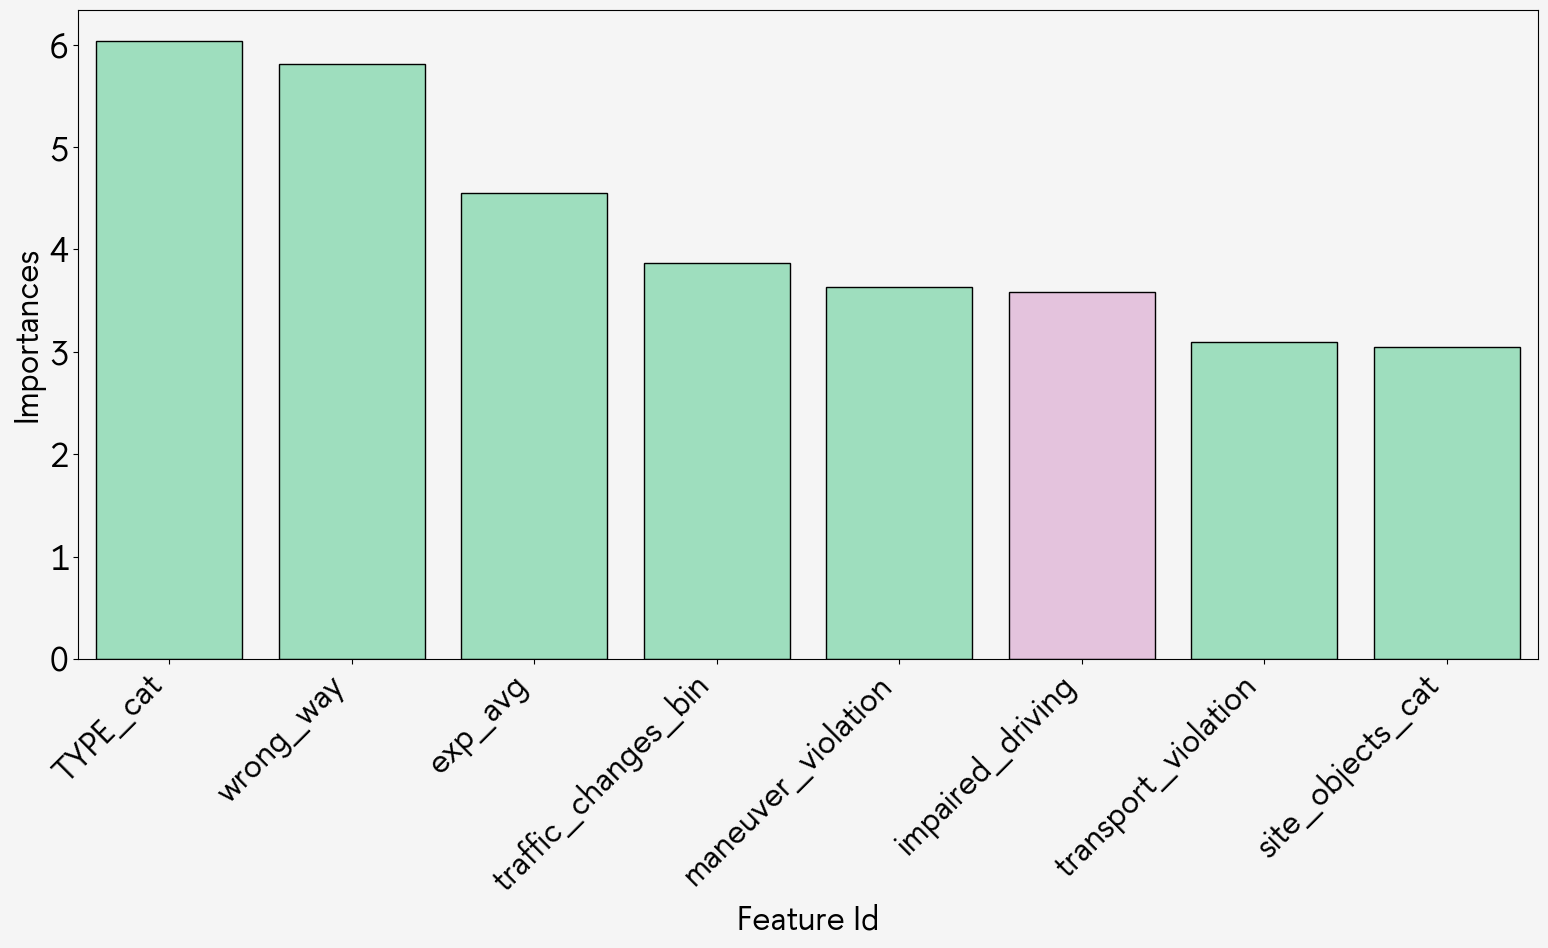

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Цвета
highlight_color = "#E9BEE0"   # светлорозовый
default_color = "#93E9BE"     # светлозелёный
edge_color = "#000000"        # чёрный
bg_color = "#F5F5F5"           # фон

# Создаём список цветов для всех столбцов
colors = [
    highlight_color if feat == "impaired_driving" else default_color
    for feat in imp['Feature Id']
]

plt.figure(figsize=(16, 10))

plt.rcParams["axes.facecolor"] = bg_color
plt.rcParams["figure.facecolor"] = bg_color
plt.rcParams['font.size'] = 24  # общий размер шрифта

sns.barplot(
    x=imp['Feature Id'],
    y=imp['Importances'],
    palette=colors,
    edgecolor=edge_color
)

plt.xticks(rotation=45, ha='right', fontsize=24, color=edge_color)
plt.yticks(fontsize=24, color=edge_color)
plt.xlabel("Feature Id", fontsize=24, color=edge_color)
plt.ylabel("Importances", fontsize=24, color=edge_color)

plt.tight_layout()
plt.savefig("features.png", facecolor=bg_color)
plt.show()


In [23]:
imp.to_csv("feature_importance.csv")

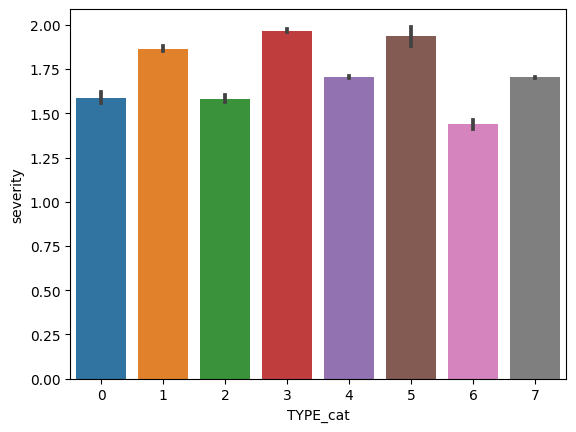

In [21]:
sns.barplot(x=data['TYPE_cat'], y=data['severity'])
plt.savefig("mean_severity_TYPES.png")